<a href="https://colab.research.google.com/github/rajarajeswarir/Hands-on-Machine-Learning/blob/main/Insurance_Cost_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Insurance cost prediction given the following details

**age**: age of primary beneficiary

**sex**: insurance contractor gender, female, male

**bmi**: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

**children**: Number of children covered by health insurance / Number of dependents

**smoker**: Smoking

**region**: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

**charges**: Individual medical costs billed by health insurance

#Load the data

In [19]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
 
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [15]:
link = 'https://drive.google.com/file/d/1-u7JkfU1g-KkapWnINPbLR3oQKsGr7Cm/view?usp=drive_link'

id = link.split("/")[-2]

# Initialize GoogleDriveFile instance with file id.
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('insurance.csv')  # Download file as 'insurance.csv'.
insurance_df = pd.read_csv('insurance.csv') 


##Take a quick look at the Data Structure

In [21]:
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [16]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


##Analysing categorical data

In [17]:
insurance_df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [18]:
insurance_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


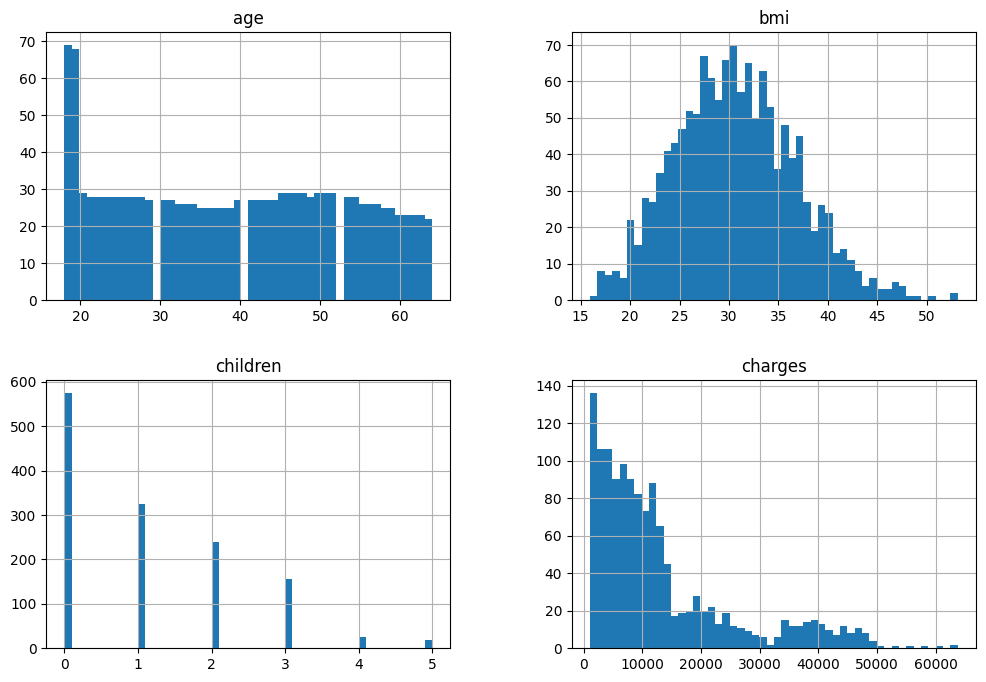

In [20]:
insurance_df.hist(bins=50, figsize=(12, 8))
plt.show()